In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [ ]:
class AirQualityDataProcessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def load_datasets(self, base_path=""):
        """
        Load all datasets from specified path
        """
        # Load geolocation data
        geo_data = pd.read_csv(f"{base_path}Jinja_2023_site_geolocation.csv")

        # Load main air quality dataset
        air_quality = pd.read_csv(f"{base_path}Jinja_2023_sites_dataset.csv")
        air_quality['timestamp'] = pd.to_datetime(air_quality['timestamp'])

        # Load population density datasets
        pop_density = pd.read_csv(f"{base_path}Jinja_pd_km2_2023.csv")
        un_pop_density = pd.read_csv(f"{base_path}Jinja_UN_pd_km2_2023.csv")

        # Load infrastructure datasets
        infra_250m = pd.read_csv(f"{base_path}Jinja_road_and_building_data_250m_2023.csv")
        infra_500m = pd.read_csv(f"{base_path}Jinja_road_and_building_data_500m_2023.csv")

        return {
            'geo': geo_data,
            'air_quality': air_quality,
            'pop_density': pop_density,
            'un_pop_density': un_pop_density,
            'infra_250m': infra_250m,
            'infra_500m': infra_500m
        }

    def merge_datasets(self, datasets):
        """
        Merge all datasets based on site_id and timestamp
        """
        # Start with air quality data as the base
        merged_data = datasets['air_quality'].copy()

        # Add population density features
        pop_density_features = pd.merge(
            datasets['pop_density'][['site_id', 'population_density']],
            datasets['un_pop_density'][['site_id', 'population_density']],
            on='site_id',
            suffixes=('_local', '_un')
        )
        merged_data = pd.merge(merged_data, pop_density_features, on='site_id')

        # Add infrastructure features
        infra_features = []
        for radius in ['250m', '500m']:
            infra_data = datasets[f'infra_{radius}'].copy()
            # Rename columns to include radius
            infra_data.columns = [
                f"{col}_{radius}" if col not in ['site_id', 'site_name', 'site_latitude', 'site_longitude']
                else col for col in infra_data.columns
            ]
            infra_features.append(infra_data)

        # Merge infrastructure features
        for infra_data in infra_features:
            merged_data = pd.merge(merged_data, infra_data, on='site_id')

        return merged_data

    def engineer_features(self, df):
        """
        Create additional features that might be useful for prediction
        """
        # Time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

        # Weather interaction features
        df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
        df['wind_effective'] = df['wind_speed'] * np.cos(np.radians(df['wind_direction']))

        # Infrastructure density ratios
        df['building_road_ratio_250m'] = (
            df['building_density_250m'] / df['road_density_250m'].replace(0, np.nan)
        ).fillna(0)
        df['building_road_ratio_500m'] = (
            df['building_density_500m'] / df['road_density_500m'].replace(0, np.nan)
        ).fillna(0)

        return df

    def prepare_for_training(self, df, target_col='pm2_5_calibrated_value'):
        """
        Prepare final dataset for model training
        """
        # Drop unnecessary columns
        cols_to_drop = [
            'Unnamed: 0', 'site_name', 'site_latitude', 'site_longitude',
            'city', 'country', 'timestamp'
        ]
        df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)

        # Handle missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

        # Scale features (excluding target)
        feature_cols = [col for col in numeric_cols if col != target_col]
        df[feature_cols] = self.scaler.fit_transform(df[feature_cols])

        # Prepare X and y
        X = df[feature_cols]
        y = df[target_col]

        return X, y

    def process_data(self, base_path=""):
        """
        Run the complete data processing pipeline
        """
        # Load all datasets
        datasets = self.load_datasets(base_path)

        # Merge datasets
        merged_data = self.merge_datasets(datasets)

        # Engineer features
        featured_data = self.engineer_features(merged_data)

        # Prepare for training
        X, y = self.prepare_for_training(featured_data)

        return X, y, featured_data

In [ ]:
# Initialize the processor
processor = AirQualityDataProcessor()

# Process the data
X, y, full_dataset = processor.process_data("/content/drive/MyDrive/MSCS_machine_learning/Air_Quality/Data/")

In [ ]:
full_dataset

,timestamp,site_id,site_name_x,pm2_5_raw_value,pm2_5_calibrated_value,pm10_raw_value,pm10_calibrated_value,site_latitude_x,site_longitude_x,temperature,...,trunk_500m,track_500m,hour,day_of_week,month,is_weekend,temp_humidity_interaction,wind_effective,building_road_ratio_250m,building_road_ratio_500m
0,2023-12-12 20:00:00+00:00,60d058c8048305120d2d6142,"Jinja Main Street, Jinja",25.289762,14.5593,26.866667,22.024919,0.432968,33.21001,21.175000,...,0.000,0.0,20,1,12,0,1880.207628,2.956525,0.062333,0.063443
1,2023-12-11 12:00:00+00:00,60d058c8048305120d2d6142,"Jinja Main Street, Jinja",13.011053,9.9803,13.410000,11.634788,0.432968,33.21001,27.516667,...,0.000,0.0,12,0,12,0,1893.146670,1.433131,0.062333,0.063443
2,2023-12-11 17:00:00+00:00,60d058c8048305120d2d6142,"Jinja Main Street, Jinja",20.304500,12.0220,21.207750,17.696175,0.432968,33.21001,22.741667,...,0.000,0.0,17,0,12,0,1827.103406,2.852065,0.062333,0.063443
3,2023-12-11 12:00:00+00:00,61238e89a033ae001e472490,"Kimaka, Jinja",10.585000,9.2352,11.955000,9.051732,0.447320,33.19295,27.516667,...,245.955,0.0,12,0,12,0,1893.146670,1.433131,0.074618,0.030477
4,2023-12-12 20:00:00+00:00,61238e89a033ae001e472490,"Kimaka, Jinja",52.416111,53.8688,67.667222,51.322867,0.447320,33.19295,21.175000,...,245.955,0.0,20,1,12,0,1880.207628,2.956525,0.074618,0.030477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58703,2023-08-23 08:00:00+00:00,615d4d04580358002aea7e89,"Kivubuka Budondo, Jinja",8.960482,12.4908,9.717911,9.381160,0.504210,33.19044,29.216667,...,0.000,0.0,8,2,8,0,1519.997078,5.485697,0.207827,0.076446
58704,2023-08-21 09:00:00+00:00,615d4d04580358002aea7e89,"Kivubuka Budondo, Jinja",9.834519,13.2032,10.585926,10.790680,0.504210,33.19044,29.192857,...,0.000,0.0,9,0,8,0,1507.811093,5.404075,0.207827,0.076446
58705,2023-08-05 09:00:00+00:00,615d4d04580358002aea7e89,"Kivubuka Budondo, Jinja",11.796000,12.9424,12.790833,10.640571,0.504210,33.19044,26.300000,...,0.000,0.0,9,5,8,1,1617.450037,3.964183,0.207827,0.076446
58706,2023-08-11 17:00:00+00:00,615d4d04580358002aea7e89,"Kivubuka Budondo, Jinja",24.015278,20.1139,28.285341,23.126890,0.504210,33.19044,22.116667,...,0.000,0.0,17,4,8,0,1645.111387,-1.823920,0.207827,0.076446


In [ ]:
df = full_dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58708 entries, 0 to 58707
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  58708 non-null  datetime64[ns, UTC]
 1   site_id                    58708 non-null  object             
 2   site_name_x                58708 non-null  object             
 3   pm2_5_raw_value            58708 non-null  float64            
 4   pm2_5_calibrated_value     58708 non-null  float64            
 5   pm10_raw_value             58708 non-null  float64            
 6   pm10_calibrated_value      57442 non-null  float64            
 7   site_latitude_x            58708 non-null  float64            
 8   site_longitude_x           58708 non-null  float64            
 9   temperature                58708 non-null  float64            
 10  humidity                   58708 non-null  float64      

In [ ]:
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       pm2_5_raw_value  pm2_5_calibrated_value  pm10_raw_value  \
count     58708.000000            58708.000000    58708.000000   
mean         32.348905               26.220286       37.811939   
std          25.947717               23.022971       30.138231   
min           1.164500                4.106600        1.145833   
25%          16.912625               13.824375       18.536447   
50%          27.532354               18.567750       31.156786   
75%          40.392125               29.200300       49.423200   
max         862.956667              211.649200      926.857500   

       pm10_calibrated_value  site_latitude_x  site_longitude_x   temperature  \
count           57442.000000     58708.000000      58708.000000  58708.000000   
mean               32.061658         0.450936         33.206111     23.609272   
std                27.175835         0.019078          0.011254      3.168675   
min                 1.002746         0.422280         33.190

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
timestamp                      0
site_id                        0
site_name_x                    0
pm2_5_raw_value                0
pm2_5_calibrated_value         0
                            ... 
is_weekend                     0
temp_humidity_interaction      0
wind_effective               888
building_road_ratio_250m       0
building_road_ratio_500m       0
Length: 61, dtype: int64


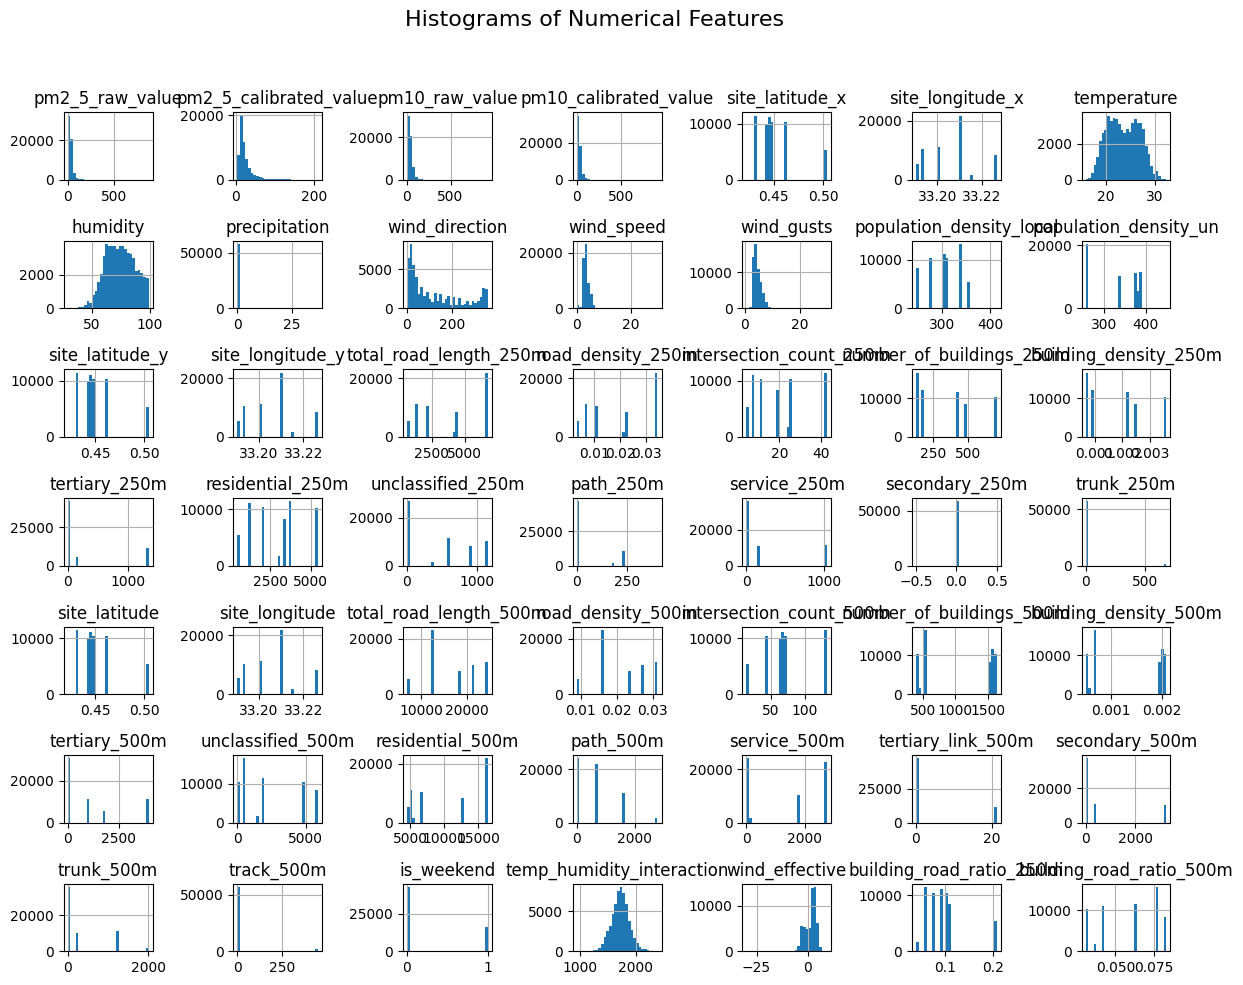

In [ ]:
# Plot histograms for key numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_features].hist(figsize=(12, 10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
